# Pre-process and write to npz for GNN training and testing

In [ ]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'

def parse_fragment_simulation(file):
    '''
    Extract info from LSDYNA txt, including particle coordinates, particle types, and effective plastic strain (eps)."
    Input: txt file extracted from LSDYNA d3plot.
    Output: np arrays of shapes, 
            tracjectory (timesteps, num_particles, 3), 
            particle_type (num_particles,), 
            eps (timesteps, num_particles).
    '''
                   
    with open(file, 'r') as f:
        lines = f.readlines() 

    # Find all "particle position" lines and "plastic strain" lines using key words
    pos_lines_start, pos_lines_end = [], []
    strain_lines_start, strain_lines_end = [], []
    for idx, line in enumerate(lines):
        if line.startswith("*NODE"):
            pos_lines_start.append(idx)
        elif line.startswith("*END"):  
            pos_lines_end.append(idx)
        elif line.startswith("$SPH_ELEMENT_RESULTS"):
            strain_lines_start.append(idx)

    num_steps = len(pos_lines_start)
    pos_lines_end, strain_lines_end = pos_lines_end[:num_steps], pos_lines_end[num_steps:]

    # Extact particle positions 
    trajectory = []
    for line_start, line_end in zip(pos_lines_start, pos_lines_end):
        pos_lines = lines[line_start:line_end]   # lines that contains positions in one time step
        pos_one_step = []
        for line in pos_lines:
            num_str = re.findall(re_int_sci, line)
            if len(num_str) == 4:
                pos = [float(x) for x in num_str] #last one is volume
                pos = tuple(pos)
                pos_one_step.append(pos)
        trajectory.append(pos_one_step) 
    trajectory = np.array(trajectory).astype(float)

    # Extract effective plastic strain (eps)
    strains = []
    for line_start, line_end in zip(strain_lines_start, strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 2:
                num = [float(x) for x in num_str] #last one is volume
                num = tuple(num)
                strains_one_step.append(num)
        strains.append(strains_one_step)  
    strains = np.array(strains).astype(float)
    
    # 
    pos_dict = {item[0]: item[1:] for item in trajectory[0, :]}
    solid_strain_dict = {item[0]: item[1:] for item in strains[0, :]}
    type_dict = {}
    beam_strain_dict = {}

    for key in pos_dict:
        if key in solid_strain_dict:
            type_dict[key] = 0
        else:
            type_dict[key] = 1
            beam_strain_dict[key] = 0.

    beam_strain = np.array(list(beam_strain_dict.items())).astype(float)
    particle_type = np.array(list(type_dict.items())).astype(int)
    strains = np.concatenate((strains, np.tile(beam_strain, (strains.shape[0], 1, 1))), axis=1)
    
    print(file, beam_strain.shape[0])
    
    # Sort based on eid
    sorted_idx = particle_type[:, 0].argsort()
    particle_type = particle_type[sorted_idx, 1]

    sorted_idx = strains[0, :, 0].argsort()
    strains = strains[:, sorted_idx, 1]

    sorted_idx = trajectory[0, :, 0].argsort()
    trajectory = trajectory[:, sorted_idx, 1:]       
        
    return trajectory, particle_type, strains


if __name__ == "__main__":
    pass

In [ ]:
import numpy as np
import pandas as pd
import glob
import json
import random
import math
import pathlib
import tqdm

dataset = 'Fragment'
in_dir = f'/home/jovyan/work/data_temp/fragment/60/'
out_dir = f'/home/jovyan/work/data_temp/fragment/{dataset}/'
metafile = '/home/jovyan/work/data_temp/fragment/GNN_Fragment.xlsx'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)
strain_mean, strain_std = 0.8868453123315391, 0.6590170029193022

# Read metadata as dict with key as the filename, and value as list of 
# ID, X, Y, Z, L, R, Mass, Concrete Strength
metadata = pd.DataFrame()
for sheet in ['60mm', '90mm', '120mm']:   
    df = pd.read_excel(metafile, sheet_name=sheet, skiprows=0, header=2)
    df = df.iloc[:, 5:12]
    df = df.rename(columns={'Unnamed: 5': 'ID'})
    df = df.dropna(subset=['ID'])
    df['ID'] = [str(x).rsplit('_', 1)[0] + str(x).rsplit('_', 1)[-1] for x in df['ID']]
    df['ID'] = sheet.split('m')[0] + '_' + df['ID']
    for col in ['Z (mm)','L (mm)','R (mm)','Mass (kg)']:
        df[col] = df[col].fillna(method='ffill')
    df['Strength (MPa)'] = [float(str(x).split('C')[-1]) for x in df['ID']]
    metadata = pd.concat([metadata, df], ignore_index=True)
metadata = metadata.groupby('ID').apply(lambda x: x.iloc[:, 1:].values.flatten().tolist()).to_dict()

# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir +'*')
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
## Current simulation are of absolute time 30 ms
## Step size=1 means 53 steps, each of which 0.6 ms
STEP_SIZE = 3

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 3)
accs = np.array([]).reshape(0, 3)
strain_stats = np.array([])
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in tqdm.tqdm(enumerate(simulations)):
    filename = simulation.split('/')[-1]
    print(f"{idx}/{n_trajectory} Reading {filename}...")
    positions, particle_types, strains = parse_fragment_simulation(simulation)
    dim = positions.shape[-1]
    
    positions = positions[20::STEP_SIZE, :, :]
    strains = strains[20::STEP_SIZE, :]
    meta = metadata[filename]
    #strains = (strains - strain_mean) / strain_std   ## standardize based on overall mean and std
    print(filename, meta)
    
    # print for debug
    print(f"Dim: {dim}")
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_types.shape}, strain: {strains.shape}")
    print(f"Unique particle types: {np.unique(particle_types)}")
    print('Meta: ', meta)
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = f'trajectory_{idx}' 
    if idx < 40:
        print('to train')
        ds_train[key] = [positions, particle_types, strains]
        file_train.append(simulation)
    if idx >= 40:
        print('to valid')
        ds_valid[key] = [positions, particle_types, strains]
        file_valid.append(simulation)
    if idx >= 40:
        print('to test')
        ds_test[key] = [positions, particle_types, strains]
        file_test.append(simulation)
        
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:]- vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, dim)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, dim)), axis=0)

# Extract vel, acc statistics for normalisation
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
np.savez(out_dir + 'train.npz', **ds_train)
np.savez(out_dir + 'valid.npz', **ds_valid)
np.savez(out_dir + 'test.npz', **ds_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
in_file = '/home/jovyan/share/gns_data/Concrete2D-C/metadata.json'
out_file = out_dir + 'metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

# In GNN, the suggested connection radius is 4.5r, or 5.625 mm (aounrd 20 neighbors)
# If R is 5 mm before normalization, 
meta_data['dim'] = 3
meta_data['default_connectivity_radius'] = 11 
meta_data['sequence_length'] = positions.shape[0]
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
meta_data['strain_mean'] = strain_mean
meta_data['strain_std'] = strain_std

meta_data['dt'] = 0.0006 * STEP_SIZE
meta_data['bounds'] = [[-500, 500], [-1000, 1000], [4, 124]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

0it [00:00, ?it/s]

0/45 Reading 60_5_0.4C30...
/home/jovyan/work/data_temp/fragment/60/60_5_0.4C30 3069
60_5_0.4C30 [34.3, 24.9, -400.0, 157.5, 78.75, 5.0, 30.0]
Dim: 3
Position min:[-498.56452   -995.           3.6501203], max:[510.9927  995.      360.88197]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [34.3, 24.9, -400.0, 157.5, 78.75, 5.0, 30.0]
to train


1it [01:26, 86.25s/it]

1/45 Reading 60_5_0.3C80...
/home/jovyan/work/data_temp/fragment/60/60_5_0.3C80 3069
60_5_0.3C80 [20.0, -35.6, -300.0, 157.5, 78.75, 5.0, 80.0]
Dim: 3
Position min:[-5.0870346e+02 -9.9500000e+02  7.2959584e-01], max:[521.94775 995.      453.97946]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [20.0, -35.6, -300.0, 157.5, 78.75, 5.0, 80.0]
to train


2it [02:54, 87.17s/it]

2/45 Reading 60_3_0.5C50...
/home/jovyan/work/data_temp/fragment/60/60_3_0.5C50 3069
60_3_0.5C50 [-35.6, -23.9, -500.0, 132.8, 66.4, 3.0, 50.0]
Dim: 3
Position min:[-505.98062   -995.           3.0085349], max:[500.49183 995.      190.00838]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-35.6, -23.9, -500.0, 132.8, 66.4, 3.0, 50.0]
to train


3it [04:17, 85.63s/it]

3/45 Reading 60_2_0.4C30...
/home/jovyan/work/data_temp/fragment/60/60_2_0.4C30 3069
60_2_0.4C30 [-21.1, 33.4, -400.0, 116.0, 58.0, 2.0, 30.0]
Dim: 3
Position min:[-497.89572   -995.           4.1626819], max:[496.35096 995.      190.90992]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-21.1, 33.4, -400.0, 116.0, 58.0, 2.0, 30.0]
to train


4it [05:39, 83.99s/it]

4/45 Reading 60_3_0.3C30...
/home/jovyan/work/data_temp/fragment/60/60_3_0.3C30 3069
60_3_0.3C30 [26.3, -27.5, -300.0, 132.8, 66.4, 3.0, 30.0]
Dim: 3
Position min:[-498.41125   -995.           4.1400956], max:[500.48873 995.      328.1335 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [26.3, -27.5, -300.0, 132.8, 66.4, 3.0, 30.0]
to train


5it [07:03, 83.99s/it]

5/45 Reading 60_6_0.4C80...
/home/jovyan/work/data_temp/fragment/60/60_6_0.4C80 3069
60_6_0.4C80 [23.6, 10.1, -400.0, 167.4, 83.7, 6.0, 80.0]
Dim: 3
Position min:[-517.39357   -995.           1.7700437], max:[524.72101 995.      363.4827 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [23.6, 10.1, -400.0, 167.4, 83.7, 6.0, 80.0]
to train


6it [08:29, 84.59s/it]

6/45 Reading 60_2_0.5C80...
/home/jovyan/work/data_temp/fragment/60/60_2_0.5C80 3069
60_2_0.5C80 [-36.4, 33.9, -500.0, 116.0, 58.0, 2.0, 80.0]
Dim: 3
Position min:[-500.91534   -995.           1.4653493], max:[502.5688  995.      129.51837]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-36.4, 33.9, -500.0, 116.0, 58.0, 2.0, 80.0]
to train


7it [09:51, 83.73s/it]

7/45 Reading 60_6_0.5C80...
/home/jovyan/work/data_temp/fragment/60/60_6_0.5C80 3069
60_6_0.5C80 [-17.6, -18.8, -500.0, 167.4, 83.7, 6.0, 80.0]
Dim: 3
Position min:[-5.2354488e+02 -9.9500000e+02  8.7309917e-01], max:[515.69236 995.      288.20681]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-17.6, -18.8, -500.0, 167.4, 83.7, 6.0, 80.0]
to train


8it [11:13, 83.33s/it]

8/45 Reading 60_3_0.3C80...
/home/jovyan/work/data_temp/fragment/60/60_3_0.3C80 3069
60_3_0.3C80 [-9.4, 19.1, -300.0, 132.8, 66.4, 3.0, 80.0]
Dim: 3
Position min:[-5.0959249e+02 -9.9500000e+02  1.0604422e-01], max:[501.83567 995.      295.93513]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-9.4, 19.1, -300.0, 132.8, 66.4, 3.0, 80.0]
to train


9it [12:34, 82.52s/it]

9/45 Reading 60_5_0.5C30...
/home/jovyan/work/data_temp/fragment/60/60_5_0.5C30 3069
60_5_0.5C30 [19.2, 16.5, -500.0, 157.5, 78.75, 5.0, 30.0]
Dim: 3
Position min:[-498.97923   -995.           4.0893866], max:[499.14268 995.      273.55089]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [19.2, 16.5, -500.0, 157.5, 78.75, 5.0, 30.0]
to train


10it [13:54, 81.86s/it]

10/45 Reading 60_4_0.5C50...
/home/jovyan/work/data_temp/fragment/60/60_4_0.5C50 3069
60_4_0.5C50 [-36.3, -25.0, -500.0, 146.2, 73.1, 4.0, 50.0]
Dim: 3
Position min:[-506.58161  -995.          3.497864], max:[502.75867 995.      231.87904]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-36.3, -25.0, -500.0, 146.2, 73.1, 4.0, 50.0]
to train


11it [15:15, 81.67s/it]

11/45 Reading 60_3_0.4C50...
/home/jovyan/work/data_temp/fragment/60/60_3_0.4C50 3069
60_3_0.4C50 [-21.2, 33.7, -400.0, 132.8, 66.4, 3.0, 50.0]
Dim: 3
Position min:[-502.70131   -995.           3.8932137], max:[500.34939 995.      244.37935]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-21.2, 33.7, -400.0, 132.8, 66.4, 3.0, 50.0]
to train


12it [16:41, 82.77s/it]

12/45 Reading 60_4_0.5C30...
/home/jovyan/work/data_temp/fragment/60/60_4_0.5C30 3069
60_4_0.5C30 [-20.6, 31.1, -500.0, 146.2, 73.1, 4.0, 30.0]
Dim: 3
Position min:[-497.97899   -995.           4.3322613], max:[498.40631 995.      241.36324]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-20.6, 31.1, -500.0, 146.2, 73.1, 4.0, 30.0]
to train


13it [18:06, 83.44s/it]

13/45 Reading 60_6_0.4C50...
/home/jovyan/work/data_temp/fragment/60/60_6_0.4C50 3069
60_6_0.4C50 [-46.7, -5.8, -400.0, 167.4, 83.7, 6.0, 50.0]
Dim: 3
Position min:[-520.44897   -995.           1.7700952], max:[502.00783 995.      382.54096]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-46.7, -5.8, -400.0, 167.4, 83.7, 6.0, 50.0]
to train


14it [19:31, 84.08s/it]

14/45 Reading 60_2_0.3C80...
/home/jovyan/work/data_temp/fragment/60/60_2_0.3C80 3069
60_2_0.3C80 [37.0, -22.9, -300.0, 116.0, 58.0, 2.0, 80.0]
Dim: 3
Position min:[-5.0217782e+02 -9.9500000e+02  7.2381513e-01], max:[502.97079 995.      228.21916]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [37.0, -22.9, -300.0, 116.0, 58.0, 2.0, 80.0]
to train


15it [20:57, 84.58s/it]

15/45 Reading 60_6_0.5C30...
/home/jovyan/work/data_temp/fragment/60/60_6_0.5C30 3069
60_6_0.5C30 [32.6, -39.9, -500.0, 167.4, 83.7, 6.0, 30.0]
Dim: 3
Position min:[-498.8192    -995.           3.2262387], max:[504.96407 995.      321.81065]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [32.6, -39.9, -500.0, 167.4, 83.7, 6.0, 30.0]
to train


16it [22:24, 85.25s/it]

16/45 Reading 60_5_0.3C50...
/home/jovyan/work/data_temp/fragment/60/60_5_0.3C50 3069
60_5_0.3C50 [46.2, 22.1, -300.0, 157.5, 78.75, 5.0, 50.0]
Dim: 3
Position min:[-501.45554   -995.           2.1492055], max:[524.34476 995.      479.39503]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [46.2, 22.1, -300.0, 157.5, 78.75, 5.0, 50.0]
to train


17it [23:50, 85.41s/it]

17/45 Reading 60_6_0.3C30...
/home/jovyan/work/data_temp/fragment/60/60_6_0.3C30 3069
60_6_0.3C30 [39.4, 6.8, -300.0, 167.4, 83.7, 6.0, 30.0]
Dim: 3
Position min:[-510.23953   -995.           3.2556413], max:[519.34556 995.      524.13866]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [39.4, 6.8, -300.0, 167.4, 83.7, 6.0, 30.0]
to train


18it [25:16, 85.84s/it]

18/45 Reading 60_6_0.3C50...
/home/jovyan/work/data_temp/fragment/60/60_6_0.3C50 3069
60_6_0.3C50 [-11.1, -24.6, -300.0, 167.4, 83.7, 6.0, 50.0]
Dim: 3
Position min:[-525.37199   -995.           2.3836841], max:[520.77531 995.      504.17877]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-11.1, -24.6, -300.0, 167.4, 83.7, 6.0, 50.0]
to train


19it [26:41, 85.35s/it]

19/45 Reading 60_4_0.4C50...
/home/jovyan/work/data_temp/fragment/60/60_4_0.4C50 3069
60_4_0.4C50 [42.6, 21.2, -400.0, 146.2, 73.1, 4.0, 50.0]
Dim: 3
Position min:[-500.06133   -995.           1.9671465], max:[505.3161  995.      306.02019]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [42.6, 21.2, -400.0, 146.2, 73.1, 4.0, 50.0]
to train


20it [28:06, 85.44s/it]

20/45 Reading 60_3_0.5C30...
/home/jovyan/work/data_temp/fragment/60/60_3_0.5C30 3069
60_3_0.5C30 [4.2, 8.2, -500.0, 132.8, 66.4, 3.0, 30.0]
Dim: 3
Position min:[-499.65064   -995.           4.4395789], max:[498.16297 995.      188.00985]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [4.2, 8.2, -500.0, 132.8, 66.4, 3.0, 30.0]
to train


21it [29:32, 85.50s/it]

21/45 Reading 60_5_0.4C50...
/home/jovyan/work/data_temp/fragment/60/60_5_0.4C50 3069
60_5_0.4C50 [11.5, 0.9, -400.0, 157.5, 78.75, 5.0, 50.0]
Dim: 3
Position min:[-502.09508   -995.           3.3699964], max:[505.57708 995.      321.6332 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [11.5, 0.9, -400.0, 157.5, 78.75, 5.0, 50.0]
to train


22it [30:57, 85.44s/it]

22/45 Reading 60_4_0.3C30...
/home/jovyan/work/data_temp/fragment/60/60_4_0.3C30 3069
60_4_0.3C30 [-28.7, 24.6, -300.0, 146.2, 73.1, 4.0, 30.0]
Dim: 3
Position min:[-512.45088  -995.          3.603997], max:[508.25233 995.      403.84507]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-28.7, 24.6, -300.0, 146.2, 73.1, 4.0, 30.0]
to train


23it [32:23, 85.53s/it]

23/45 Reading 60_3_0.3C50...
/home/jovyan/work/data_temp/fragment/60/60_3_0.3C50 3069
60_3_0.3C50 [40.7, -27.9, -300.0, 132.8, 66.4, 3.0, 50.0]
Dim: 3
Position min:[-499.61404   -995.           3.4341695], max:[500.88856 995.      327.5733 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [40.7, -27.9, -300.0, 132.8, 66.4, 3.0, 50.0]
to train


24it [33:48, 85.53s/it]

24/45 Reading 60_6_0.3C80...
/home/jovyan/work/data_temp/fragment/60/60_6_0.3C80 3069
60_6_0.3C80 [-47.8, -22.3, -300.0, 167.4, 83.7, 6.0, 80.0]
Dim: 3
Position min:[-537.80764   -995.          -1.8479476], max:[513.45402 995.      532.3664 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-47.8, -22.3, -300.0, 167.4, 83.7, 6.0, 80.0]
to train


25it [35:14, 85.64s/it]

25/45 Reading 60_2_0.3C30...
/home/jovyan/work/data_temp/fragment/60/60_2_0.3C30 3069
60_2_0.3C30 [19.3, -8.3, -300.0, 116.0, 58.0, 2.0, 30.0]
Dim: 3
Position min:[-496.52926   -995.           4.0081936], max:[497.1608  995.      238.92065]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [19.3, -8.3, -300.0, 116.0, 58.0, 2.0, 30.0]
to train


26it [36:40, 85.66s/it]

26/45 Reading 60_2_0.4C80...
/home/jovyan/work/data_temp/fragment/60/60_2_0.4C80 3069
60_2_0.4C80 [49.0, 3.5, -400.0, 116.0, 58.0, 2.0, 80.0]
Dim: 3
Position min:[-502.59719   -995.           1.1119388], max:[502.43363 995.      160.49684]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [49.0, 3.5, -400.0, 116.0, 58.0, 2.0, 80.0]
to train


27it [38:06, 85.70s/it]

27/45 Reading 60_2_0.3C50...
/home/jovyan/work/data_temp/fragment/60/60_2_0.3C50 3069
60_2_0.3C50 [39.9, -14.4, -300.0, 116.0, 58.0, 2.0, 50.0]
Dim: 3
Position min:[-498.32967   -995.           3.5327472], max:[500.02515 995.      241.63088]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [39.9, -14.4, -300.0, 116.0, 58.0, 2.0, 50.0]
to train


28it [39:32, 85.76s/it]

28/45 Reading 60_3_0.5C80...
/home/jovyan/work/data_temp/fragment/60/60_3_0.5C80 3069
60_3_0.5C80 [-9.5, -35.5, -500.0, 132.8, 66.4, 3.0, 80.0]
Dim: 3
Position min:[-504.33435   -995.           1.3678261], max:[501.90741 995.      164.37021]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-9.5, -35.5, -500.0, 132.8, 66.4, 3.0, 80.0]
to train


29it [40:58, 85.97s/it]

29/45 Reading 60_2_0.4C50...
/home/jovyan/work/data_temp/fragment/60/60_2_0.4C50 3069
60_2_0.4C50 [27.6, -29.4, -400.0, 116.0, 58.0, 2.0, 50.0]
Dim: 3
Position min:[-498.02782   -995.           3.6046638], max:[500.52813 995.      172.99369]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [27.6, -29.4, -400.0, 116.0, 58.0, 2.0, 50.0]
to train


30it [42:25, 86.28s/it]

30/45 Reading 60_4_0.5C80...
/home/jovyan/work/data_temp/fragment/60/60_4_0.5C80 3069
60_4_0.5C80 [-2.3, 33.4, -500.0, 146.2, 73.1, 4.0, 80.0]
Dim: 3
Position min:[-5.1095409e+02 -9.9500000e+02 -8.4579227e-01], max:[510.12853 995.      204.11831]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [-2.3, 33.4, -500.0, 146.2, 73.1, 4.0, 80.0]
to train


31it [43:51, 86.15s/it]

31/45 Reading 60_3_0.4C80...
/home/jovyan/work/data_temp/fragment/60/60_3_0.4C80 3069
60_3_0.4C80 [26.8, -45.6, -400.0, 132.8, 66.4, 3.0, 80.0]
Dim: 3
Position min:[-5.0196006e+02 -9.9500000e+02  4.5533392e-01], max:[506.99535 995.      231.86669]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [26.8, -45.6, -400.0, 132.8, 66.4, 3.0, 80.0]
to train


32it [45:20, 86.95s/it]

32/45 Reading 60_4_0.3C50...
/home/jovyan/work/data_temp/fragment/60/60_4_0.3C50 3069
60_4_0.3C50 [19.5, -45.9, -300.0, 146.2, 73.1, 4.0, 50.0]
Dim: 3
Position min:[-502.04589   -995.           3.7349615], max:[502.72175 995.      397.7614 ]
Strain min:0.0, max:1.9999999
Shape, pos: (28, 123069, 3), types: (123069,), strain: (28, 123069)
Unique particle types: [0 1]
Meta:  [19.5, -45.9, -300.0, 146.2, 73.1, 4.0, 50.0]
to train


33it [46:46, 86.80s/it]

33/45 Reading 60_4_0.4C30...


# Read MPS

In [ ]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'

def parse_fragment_mps(file):
    '''
    Extract info from LSDYNA txt, including particle coordinates, particle types, and effective plastic strain (eps)."
    Input: Txt from LYDYNA, e.g., C_80_480_Cc_20_strain.txt
    Output: np arrays of shapes, 
            tracjectory (timesteps, num_particles, 3), particle_type (num_particles,), eps (timesteps, num_particles).
    '''
                   
    with open(file, 'r') as f:
        lines = f.readlines() 

    # Find all "particle position" lines and "plastic strain" lines using key words
    strain_lines_start, strain_lines_end = [], []
    for idx, line in enumerate(lines):
        if line.startswith("$RESULT OF  Max Prin Strain"):
            strain_lines_start.append(idx)
        elif line.startswith("*END"):
            strain_lines_end.append(idx)

    # Extract effective plastic strain (eps)
    strains = []
    for line_start, line_end in zip(strain_lines_start, strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 1:
                num = float(num_str[0]) 
                strains_one_step.append(num)
        strains_one_step = [0]*6248 + strains_one_step   # Add zero strain to all beam particles
        strains.append(strains_one_step)  
    strains = np.array(strains).astype(float)
    
    return strains


if __name__ == "__main__":
    pass

In [ ]:
file = '/home/jovyan/work/data_temp/fragment/120_4_0.3C50'
trajectory, particle_types, strains = parse_fragment_simulation(file)
print(trajectory.shape, particle_types.shape, strains.shape)

# Modify metadata

In [ ]:
in_file = '/home/jovyan/share/gns_data/Fragment/metadata.json'
out_file = f'/home/jovyan/work/data_temp/fragment/Fragment/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

meta_data['dim'] = 3
meta_data['bounds'] = [[-500, 500], [-1000, 1000], [0, 255]]

print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

# Test regular expression for number extraction

In [ ]:
import re

strs = ['20742   1.4952594e+03   -1.0499660e+02   1.6313647e-02   9.9995575e+02',
        '    32365   1.4051317e+00',
        '   10826       1   15757   15758   15784   15783   11311   11312   11338   11337',
        '$Total Solid element Volume =    7.5878880e+07'
       ]

pattern = r'[+-]?\d+\.\d+e[+-]?[\d]+'
for str in strs:
    print(re.findall(pattern, str))
    
pattern = r'[-\d\.]+e?[-+\d]*'
for str in strs:
    print(re.findall(pattern, str))

# Plot Fragment data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


# Create a colormap
cmap = plt.get_cmap("rainbow")

# Create a 3D scatter plot with custom figure size
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 2, 0.1])

# Initial scatter plot
scatter = ax.scatter([], [], [], c=[], cmap=cmap, vmin=strains.min(), vmax=strains.max())

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label("Strain")

# Set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


def update(timestep):
    ax.clear()
    ax.set_box_aspect([4, 8, 1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    ax.set_title(f"Time step: {timestep}")

    pos = position[timestep]
    strains_t = strain[timestep]
    scatter = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=strains_t, cmap=cmap)

    return scatter,


ani = FuncAnimation(fig, update, frames=range(strains.shape[0]), interval=200, blit=False)

# Uncomment the following line to save the animation as a GIF
ani.save("pred.gif", writer="pillow", fps=5, dpi=50)

In [ ]:
import pickle

path = '/home/jovyan/work/data_temp/fragment/Fragment/test.npz'
data = [item for _, item in np.load(path, allow_pickle=True).items()]

print(data[0][2].shape)

In [94]:
file = "/home/jovyan/work/data_temp/fragment/60/60_2_0.5C30"
pos, type, strain = parse_fragment_simulation(file)

/home/jovyan/work/data_temp/fragment/60/60_2_0.5C30 3069


In [47]:
print(pos.shape, type.shape, strain.shape)
print(np.unique(type))

(101, 246248, 3) (246248,) (101, 246248)
[0 1]


Text(0.5, 0, 'Z')

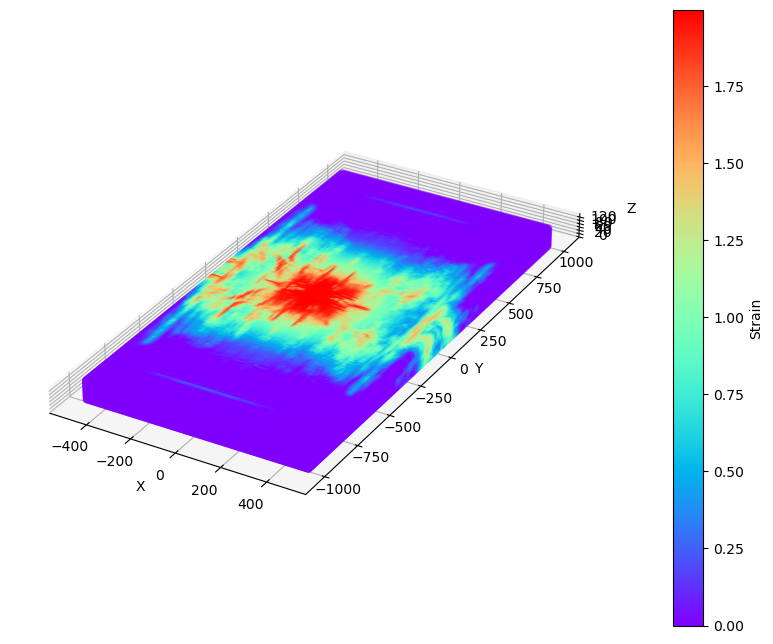

In [92]:
import matplotlib.pyplot as plt

step = 20
mask = type == 0

xyz = pos[step, mask]
strain_t = strain[step, mask]

# Create a colormap
cmap = plt.get_cmap("rainbow")

# Create a 3D scatter plot with custom figure size
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 2, 0.1])

# Initial scatter plot
scatter = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=strain_t, cmap=cmap, vmin=strain_t.min(), vmax=strain_t.max())

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label("Strain")

# Set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [109]:
metafile = '/home/jovyan/work/data_temp/fragment/GNN_Fragment.xlsx'

metadata = pd.DataFrame()
for sheet in ['60mm', '90mm', '120mm']:   
    df = pd.read_excel(metafile, sheet_name=sheet, skiprows=0, header=2)
    df = df.iloc[:, 5:12]
    df = df.rename(columns={'Unnamed: 5': 'ID'})
    df = df.dropna(subset=['ID'])
    df['ID'] = [str(x).rsplit('_', 1)[0] + str(x).rsplit('_', 1)[-1] for x in df['ID']]
    df['ID'] = sheet.split('m')[0] + '_' + df['ID']
    for col in ['Z (mm)','L (mm)','R (mm)','Mass (kg)']:
        df[col] = df[col].fillna(method='ffill')
    df['Strength (MPa)'] = [float(str(x).split('C')[-1]) for x in df['ID']]
    metadata = pd.concat([metadata, df], ignore_index=True)
metadata = metadata.groupby('ID').apply(lambda x: x.iloc[:, 1:].values.flatten().tolist()).to_dict()

simulation = '90_4_0.3C50'
meta = metadata[simulation]
print(meta)

[-31.0, 33.3, -300.0, 146.2, 73.1, 4.0, 50.0]
